### Imports

In [ ]:
using Random
using Flux, Statistics, ProgressMeter, Plots, TaijaData, Distances, MLDatasets, CSV, DataFrames
using Flux: onehotbatch, onecold, crossentropy, logitcrossentropy, mse, throttle, update!, push!

include("attacks.jl")
include("train.jl")

   Resolving package versions...
    Updating `~/.julia/environments/v1.11/Project.toml`
  [a93c6f00] + DataFrames v1.7.0
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`


adversarial_train (generic function with 1 method)

### Setting up MNIST data

In [ ]:
train_df = CSV.read("../data/mnist_train.csv", DataFrame; header=false)
train_data = Matrix(train_df)

test_df = CSV.read("../data/mnist_test.csv", DataFrame; header=false)
test_data = Matrix(test_df)

x_train = train_data[:, 2:785]' ./ 255
y_train = train_data[:, 1]

x_test = test_data[:, 2:785]' ./ 255
y_test = test_data[:, 1]

x_train

784×60000 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮              ⋱            ⋮                   
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 

### Defining model architecture (MLP)

In [21]:
model = Chain(
    Dense(784, 128, relu; init=Flux.glorot_normal),
    Dense(128,  10; init=Flux.glorot_normal)
)

adv_pgd_strong = deepcopy(model)
adv_pgd_medium = deepcopy(model)
adv_pgd_weak = deepcopy(model)

spare = deepcopy(model)

Chain(
  Dense(784 => 128, relu),              # 100_480 parameters
  Dense(128 => 10),                     # 1_290 parameters
)                   # Total: 4 arrays, 101_770 parameters, 397.742 KiB.

### Training and attack hyperparameters

In [24]:
loss(x, y) = logitcrossentropy(x, y) # Not defining softmax in the model to help with CE
batch_size = 32
epochs = 20
clamp_range = (0, 1)
opt = Flux.Adam()

Adam(0.001, (0.9, 0.999), 1.0e-8, IdDict{Any, Any}())

### Model Training

#### Classical training: No adversarial robustness in training loop

In [26]:
include("train.jl")

vanilla_losses = vanilla_train(model, loss, opt, x_train, y_train, epochs, batch_size, 0, 9)

Epoch: 1


┌ Warning: Layer with Float32 parameters got Float64 input.
│   The input will be converted, but any earlier layers may be very slow.
│   layer = Dense(784 => 128, relu)
│   summary(x) = 784×32 Matrix{Float64}
└ @ Flux /root/.julia/packages/Flux/97jpP/src/layers/stateless.jl:59


Average loss: 0.26102784001529217
Epoch: 2
Average loss: 0.11678759016046922


Progress:  10%|████▏                                    |  ETA: 0:02:51

Epoch: 3
Average loss: 0.07954412010206531


Progress:  15%|██████▏                                  |  ETA: 0:02:12

Epoch: 4
Average loss: 0.05975129395748178


Progress:  20%|████████▎                                |  ETA: 0:01:48

Epoch: 5
Average loss: 0.046564727185014636


Progress:  25%|██████████▎                              |  ETA: 0:01:31

Epoch: 6
Average loss: 0.035245799549017104


Progress:  30%|████████████▎                            |  ETA: 0:01:19

Epoch: 7
Average loss: 0.028744991099694743


Progress:  35%|██████████████▍                          |  ETA: 0:01:09

Epoch: 8
Average loss: 0.02367387277750143


Progress:  40%|████████████████▍                        |  ETA: 0:01:01

Epoch: 9
Average loss: 0.019624248573704


Progress:  45%|██████████████████▌                      |  ETA: 0:00:54

Epoch: 10
Average loss: 0.015912138190677313


Progress:  50%|████████████████████▌                    |  ETA: 0:00:48

Epoch: 11
Average loss: 0.013372676805521769


Progress:  55%|██████████████████████▌                  |  ETA: 0:00:42

Epoch: 12
Average loss: 0.011994637238713525


Progress:  60%|████████████████████████▋                |  ETA: 0:00:37

Epoch: 13
Average loss: 0.01094605422011373


Progress:  65%|██████████████████████████▋              |  ETA: 0:00:31

Epoch: 14
Average loss: 0.008083798682364916


Progress:  70%|████████████████████████████▊            |  ETA: 0:00:27

Epoch: 15
Average loss: 0.008139687181971385


Progress:  75%|██████████████████████████████▊          |  ETA: 0:00:23

Epoch: 16
Average loss: 0.007925119089922616


Progress:  80%|████████████████████████████████▊        |  ETA: 0:00:18

Epoch: 17
Average loss: 0.006893724629442053


Progress:  85%|██████████████████████████████████▉      |  ETA: 0:00:13

Epoch: 18
Average loss: 0.0052621438711599085


Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:09

Epoch: 19
Average loss: 0.006989961071774997


Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:04

Epoch: 20
Average loss: 0.00468719041000392


Progress: 100%|█████████████████████████████████████████| Time: 0:01:27


20-element Vector{Any}:
 0.26102784001529217
 0.11678759016046922
 0.07954412010206531
 0.05975129395748178
 0.046564727185014636
 0.035245799549017104
 0.028744991099694743
 0.02367387277750143
 0.019624248573704
 0.015912138190677313
 0.013372676805521769
 0.011994637238713525
 0.01094605422011373
 0.008083798682364916
 0.008139687181971385
 0.007925119089922616
 0.006893724629442053
 0.0052621438711599085
 0.006989961071774997
 0.00468719041000392

#### Weak adversarial training: PGD with step size 0.01, 7 iterations and eps 0.05

In [28]:
adversarial_losses_weak = adversarial_train(adv_pgd_weak, loss, opt, x_train, y_train, epochs, batch_size, PGD, 0, 9, 0.05; attack_method=:PGD, iterations=7, step_size=0.01, clamp_range=clamp_range)

Epoch: 1
Average loss: 0.6438688881615797
Epoch: 2
Average loss: 0.30413974053462345


Progress:  10%|████▏                                    |  ETA: 0:03:12

Epoch: 3
Average loss: 0.22296262778937817


Progress:  15%|██████▏                                  |  ETA: 0:02:51

Epoch: 4
Average loss: 0.17840217874546846


Progress:  20%|████████▎                                |  ETA: 0:02:35

Epoch: 5
Average loss: 0.14703907472739616


Progress:  25%|██████████▎                              |  ETA: 0:02:23

Epoch: 6
Average loss: 0.1263425684945037


Progress:  30%|████████████▎                            |  ETA: 0:02:14

Epoch: 7
Average loss: 0.11003219519394139


Progress:  35%|██████████████▍                          |  ETA: 0:02:03

Epoch: 8
Average loss: 0.09394153114054352


Progress:  40%|████████████████▍                        |  ETA: 0:01:53

Epoch: 9
Average loss: 0.08327058504537369


Progress:  45%|██████████████████▌                      |  ETA: 0:01:42

Epoch: 10
Average loss: 0.07472140175864721


Progress:  50%|████████████████████▌                    |  ETA: 0:01:32

Epoch: 11
Average loss: 0.06631582780236689


Progress:  55%|██████████████████████▌                  |  ETA: 0:01:23

Epoch: 12
Average loss: 0.0620172512986542


Progress:  60%|████████████████████████▋                |  ETA: 0:01:13

Epoch: 13
Average loss: 0.051394192260984954


Progress:  65%|██████████████████████████▋              |  ETA: 0:01:03

Epoch: 14
Average loss: 0.04955535272916313


Progress:  70%|████████████████████████████▊            |  ETA: 0:00:54

Epoch: 15
Average loss: 0.04533582456213577


Progress:  75%|██████████████████████████████▊          |  ETA: 0:00:45

Epoch: 16
Average loss: 0.040875585250424534


Progress:  80%|████████████████████████████████▊        |  ETA: 0:00:35

Epoch: 17
Average loss: 0.038703728776529896


Progress:  85%|██████████████████████████████████▉      |  ETA: 0:00:26

Epoch: 18
Average loss: 0.03469541547795913


Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:17

Epoch: 19
Average loss: 0.032787198475814266


Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:08

Epoch: 20
Average loss: 0.02993002186972832


Progress: 100%|█████████████████████████████████████████| Time: 0:02:44


20-element Vector{Any}:
 0.6438688881615797
 0.30413974053462345
 0.22296262778937817
 0.17840217874546846
 0.14703907472739616
 0.1263425684945037
 0.11003219519394139
 0.09394153114054352
 0.08327058504537369
 0.07472140175864721
 0.06631582780236689
 0.0620172512986542
 0.051394192260984954
 0.04955535272916313
 0.04533582456213577
 0.040875585250424534
 0.038703728776529896
 0.03469541547795913
 0.032787198475814266
 0.02993002186972832

#### Medium Adversarial Training: PGD with step size 0.01, 13 iterations and eps 0.1

In [29]:
adversarial_losses_medium = adversarial_train(adv_pgd_medium, loss, opt, x_train, y_train, epochs, batch_size, PGD, 0, 9, 0.1; attack_method=:PGD, iterations=13, step_size=0.01, clamp_range=clamp_range)

Epoch: 1
Average loss: 1.0008164931297303
Epoch: 2
Average loss: 0.5653837557792664


Progress:  10%|████▏                                    |  ETA: 0:03:28

Epoch: 3
Average loss: 0.4680757397373517


Progress:  15%|██████▏                                  |  ETA: 0:03:24

Epoch: 4
Average loss: 0.41865252505143485


Progress:  20%|████████▎                                |  ETA: 0:03:17

Epoch: 5
Average loss: 0.3871162989517053


Progress:  25%|██████████▎                              |  ETA: 0:03:10

Epoch: 6
Average loss: 0.36236929145852725


Progress:  30%|████████████▎                            |  ETA: 0:03:02

Epoch: 7
Average loss: 0.3416511021782955


Progress:  35%|██████████████▍                          |  ETA: 0:02:56

Epoch: 8
Average loss: 0.32424842346707977


Progress:  40%|████████████████▍                        |  ETA: 0:02:47

Epoch: 9
Average loss: 0.31468819087147715


Progress:  45%|██████████████████▌                      |  ETA: 0:02:39

Epoch: 10
Average loss: 0.30299900081058345


Progress:  50%|████████████████████▌                    |  ETA: 0:02:26

Epoch: 11
Average loss: 0.2938104329943657


Progress:  55%|██████████████████████▌                  |  ETA: 0:02:12

Epoch: 12
Average loss: 0.2854473121702671


Progress:  60%|████████████████████████▋                |  ETA: 0:01:58

Epoch: 13
Average loss: 0.27898213224659363


Progress:  65%|██████████████████████████▋              |  ETA: 0:01:43

Epoch: 14
Average loss: 0.2720734828735391


Progress:  70%|████████████████████████████▊            |  ETA: 0:01:29

Epoch: 15
Average loss: 0.2673913002431393


Progress:  75%|██████████████████████████████▊          |  ETA: 0:01:14

Epoch: 16
Average loss: 0.26287253640890124


Progress:  80%|████████████████████████████████▊        |  ETA: 0:01:00

Epoch: 17
Average loss: 0.25750101493597033


Progress:  85%|██████████████████████████████████▉      |  ETA: 0:00:45

Epoch: 18
Average loss: 0.2536151811818282


Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:30

Epoch: 19
Average loss: 0.2531742242778341


Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:15

Epoch: 20
Average loss: 0.24875998517970244


Progress: 100%|█████████████████████████████████████████| Time: 0:05:02


20-element Vector{Any}:
 1.0008164931297303
 0.5653837557792664
 0.4680757397373517
 0.41865252505143485
 0.3871162989517053
 0.36236929145852725
 0.3416511021782955
 0.32424842346707977
 0.31468819087147715
 0.30299900081058345
 0.2938104329943657
 0.2854473121702671
 0.27898213224659363
 0.2720734828735391
 0.2673913002431393
 0.26287253640890124
 0.25750101493597033
 0.2536151811818282
 0.2531742242778341
 0.24875998517970244

#### Strong Adversarial Training: PGD with step size 0.01, 40 iterations and eps 0.3

In [30]:
adversarial_losses_strong = adversarial_train(adv_pgd_strong, loss, opt, x_train, y_train, epochs, batch_size, PGD, 0, 9, 0.3; attack_method=:PGD, iterations=40, step_size=0.01, clamp_range=clamp_range)

Epoch: 1
Average loss: 2.8022659251530966
Epoch: 2
Average loss: 2.3212887631734214


Progress:  10%|████▏                                    |  ETA: 0:14:29

Epoch: 3
Average loss: 2.2008011558532714


Progress:  15%|██████▏                                  |  ETA: 0:13:59

Epoch: 4
Average loss: 2.127428648249308


Progress:  20%|████████▎                                |  ETA: 0:12:42

Epoch: 5
Average loss: 2.0670884188334147


Progress:  25%|██████████▎                              |  ETA: 0:11:41

Epoch: 6
Average loss: 2.0232179655075075


Progress:  30%|████████████▎                            |  ETA: 0:11:14

Epoch: 7
Average loss: 1.9992621312459309


Progress:  35%|██████████████▍                          |  ETA: 0:10:23

Epoch: 8
Average loss: 1.9710062896728515


Progress:  40%|████████████████▍                        |  ETA: 0:09:31

Epoch: 9
Average loss: 1.9471116401036581


Progress:  45%|██████████████████▌                      |  ETA: 0:08:49

Epoch: 10
Average loss: 1.9253686906814576


Progress:  50%|████████████████████▌                    |  ETA: 0:07:57

Epoch: 11
Average loss: 1.9129828539530436


Progress:  55%|██████████████████████▌                  |  ETA: 0:07:10

Epoch: 12
Average loss: 1.9036810992558797


Progress:  60%|████████████████████████▋                |  ETA: 0:06:22

Epoch: 13
Average loss: 1.8937930795669555


Progress:  65%|██████████████████████████▋              |  ETA: 0:05:36

Epoch: 14
Average loss: 1.8811665307362875


Progress:  70%|████████████████████████████▊            |  ETA: 0:04:47

Epoch: 15
Average loss: 1.8748154895146687


Progress:  75%|██████████████████████████████▊          |  ETA: 0:03:58

Epoch: 16
Average loss: 1.8669566420237222


Progress:  80%|████████████████████████████████▊        |  ETA: 0:03:10

Epoch: 17
Average loss: 1.8584758113861084


Progress:  85%|██████████████████████████████████▉      |  ETA: 0:02:22

Epoch: 18
Average loss: 1.849341175142924


Progress:  90%|████████████████████████████████████▉    |  ETA: 0:01:34

Epoch: 19
Average loss: 1.8468084585825602


Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:47

Epoch: 20
Average loss: 1.8454012526830037


Progress: 100%|█████████████████████████████████████████| Time: 0:15:41


20-element Vector{Any}:
 2.8022659251530966
 2.3212887631734214
 2.2008011558532714
 2.127428648249308
 2.0670884188334147
 2.0232179655075075
 1.9992621312459309
 1.9710062896728515
 1.9471116401036581
 1.9253686906814576
 1.9129828539530436
 1.9036810992558797
 1.8937930795669555
 1.8811665307362875
 1.8748154895146687
 1.8669566420237222
 1.8584758113861084
 1.849341175142924
 1.8468084585825602
 1.8454012526830037

### Exploratory plotting

#### Random clean and FGSM-attacked image: Classically trained model

Digit predicted by the model for the clean image: 9
Digit predicted by the model for the 
    adversarial image: 7
True label: 9


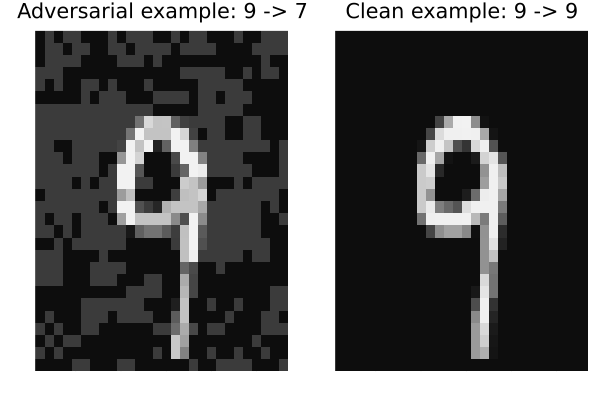

In [32]:
include("../utils/plot.jl")

plot_mnist_clean_and_attack(x_train, y_train, FGSM, model, loss, 0.2; iterations=40, step_size=0.03)

#### Random clean and FGSM-attacked image: Strong AT model

Digit predicted by the model for the clean image: 9
Digit predicted by the model for the 
    adversarial image: 9
True label: 9


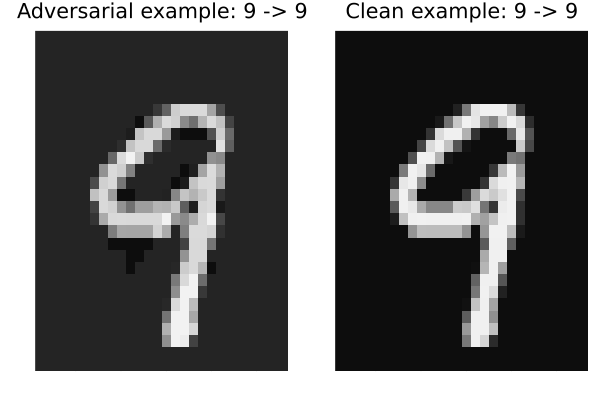

In [33]:
plot_mnist_clean_and_attack(x_test, y_test, FGSM, adv_pgd_strong, loss, 0.1; step_size=0.01, iterations=40, attack_method= :FGSM)

### Model evaluation (clean and robust accuracy)

#### Classically-trained model

In [34]:
include("evaluate.jl")

overview = evaluate_model(x_test, y_test, 0, 9, model, loss, FGSM, 0.2; iterations=40, attack_method=:FGSM)

overview

Dict{Any, Any} with 4 entries:
  "adversary_forced_error" => 9574
  "clean_accuracy"         => 0.9787
  "adversary_changed"      => 9587
  "adversarial_accuracy"   => 0.0213

#### Weak AT

In [35]:
overview = evaluate_model(x_test, y_test, 0, 9, adv_pgd_weak, loss, FGSM, 0.2; iterations=40, attack_method=:FGSM)

overview

Dict{Any, Any} with 4 entries:
  "adversary_forced_error" => 7493
  "clean_accuracy"         => 0.9847
  "adversary_changed"      => 7499
  "adversarial_accuracy"   => 0.2354

#### Medium AT

In [37]:
overview = evaluate_model(x_test, y_test, 0, 9, adv_pgd_medium, loss, FGSM, 0.2; iterations=40, attack_method=:FGSM)

overview

Dict{Any, Any} with 4 entries:
  "adversary_forced_error" => 5519
  "clean_accuracy"         => 0.9834
  "adversary_changed"      => 5529
  "adversarial_accuracy"   => 0.4315

#### Strong AT

In [38]:
overview = evaluate_model(x_test, y_test, 0, 9, adv_pgd_strong, loss, FGSM, 0.2; iterations=40, attack_method=:FGSM)

overview

Dict{Any, Any} with 4 entries:
  "adversary_forced_error" => 2568
  "clean_accuracy"         => 0.97
  "adversary_changed"      => 2612
  "adversarial_accuracy"   => 0.7134

### Saving our models

In [40]:
using ONNXNaiveNASflux

ONNXNaiveNASflux.save("../models/adv_pgd_strong.onnx", adv_pgd_strong)
ONNXNaiveNASflux.save("../models/adv_pgd_medium.onnx", adv_pgd_medium)
ONNXNaiveNASflux.save("../models/adv_pgd_weak.onnx", adv_pgd_weak)
ONNXNaiveNASflux.save("../models/classically_trained.onnx", model)
ONNXNaiveNASflux.save("../models/spare.onnx", spare)

407481